In [1]:
import sys 
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

CHECKPOINTS_DIR = '../logs/notebook_runs/segmentation/checkpoints'
def checkpoint_path(name, epoch):
    return f'{CHECKPOINTS_DIR}/{name}_checkpoint.pth'

In [2]:
from src.data.exact.dataset.segmentation_dataset import BModeSegmentationDataset
from src.modeling.unet import UNet
from src.data.exact.splits import Splits, HasProstateMaskFilter

from src.data.exact.segmentation_transforms import SegmentationTransform

splits = Splits(
    cohort_specifier=['UVA600', 'CRCEO428'], 
    merge_test_centers=True, 
    merge_train_centers=True, 
    merge_val_centers=True,
)
splits.apply_filters(HasProstateMaskFilter())

train_transform = SegmentationTransform(use_augmentations=False)
eval_transform = SegmentationTransform(use_augmentations=False)

train_dataset = BModeSegmentationDataset(
    splits.get_train(), 
    transform=train_transform,
)

val_dataset = BModeSegmentationDataset(
    splits.get_val(),
    transform=eval_transform,
)

In [13]:
from src.modeling.segmentation.metrics import dice_score
from tqdm.notebook import tqdm

def train_epoch(model, optimizer, loss_fn, train_loader, device):
    model.train()
    train_loss = 0
    train_dice = 0
    for batch_idx, (data, target, *_) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_dice += dice_score(output, target)
    train_loss /= len(train_loader)
    train_dice /= len(train_loader)
    return train_loss, train_dice

def eval_epoch(model, loss_fn, val_loader, device):
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for batch_idx, (data, target, *_) in enumerate(tqdm(val_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            val_loss += loss.item()
            val_dice += dice_score(output, target)
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    return val_loss, val_dice

def train(model, optimizer, loss_fn, train_loader, val_loader, device, epochs=10):
    train_loss = []
    train_dice = []
    val_loss = []
    val_dice = []
    best_loss = np.inf
    for epoch in range(epochs):
        train_epoch_loss, train_epoch_dice = train_epoch(model, optimizer, loss_fn, train_loader, device)
        val_epoch_loss, val_epoch_dice = eval_epoch(model, loss_fn, val_loader, device)
        train_loss.append(train_epoch_loss)
        train_dice.append(train_epoch_dice)
        val_loss.append(val_epoch_loss)
        if val_epoch_loss < best_loss:
            print(f"Validation loss improved from {best_loss:.4f} to {val_epoch_loss:.4f}")
            best_loss = val_epoch_loss
            print("Saving model")
            torch.save(model.state_dict(), "best_model.pt")
        val_dice.append(val_epoch_dice)
        print(f"Epoch {epoch} Train Loss: {train_epoch_loss:.4f} Train Dice: {train_epoch_dice:.4f} Val Loss: {val_epoch_loss:.4f} Val Dice: {val_epoch_dice:.4f}")
    return train_loss, train_dice, val_loss, val_dice

In [14]:

loss_fn = lambda x, y: F.cross_entropy(x, y.long())
device = 'cuda:1'

model = UNet(1, 2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_loader = data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
val_loader = data.DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4)

# test that the model runs
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    img, target_mask, *_ = sample_batch
    img = img.to(device)
    target_mask = target_mask.to(device)
    output = model(img)
    loss = loss_fn(output, target_mask)

    dice = dice_score(output, target_mask)

In [15]:

train_loss, train_dice, val_loss, val_dice = train(model, optimizer, loss_fn, train_loader, val_loader, device, epochs=10)


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from inf to 0.5324
Saving model
Epoch 0 Train Loss: 0.5192 Train Dice: 0.6821 Val Loss: 0.5324 Val Dice: 0.7047


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from 0.5324 to 0.4761
Saving model
Epoch 1 Train Loss: 0.4522 Train Dice: 0.7224 Val Loss: 0.4761 Val Dice: 0.6624


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2 Train Loss: 0.4163 Train Dice: 0.7432 Val Loss: 0.7133 Val Dice: 0.6816


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from 0.4761 to 0.3953
Saving model
Epoch 3 Train Loss: 0.4011 Train Dice: 0.7597 Val Loss: 0.3953 Val Dice: 0.7606


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from 0.3953 to 0.3837
Saving model
Epoch 4 Train Loss: 0.3823 Train Dice: 0.7706 Val Loss: 0.3837 Val Dice: 0.7828


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from 0.3837 to 0.3610
Saving model
Epoch 5 Train Loss: 0.3743 Train Dice: 0.7767 Val Loss: 0.3610 Val Dice: 0.7989


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.3596 Train Dice: 0.7881 Val Loss: 0.4952 Val Dice: 0.7343


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.3483 Train Dice: 0.7974 Val Loss: 0.3935 Val Dice: 0.7526


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.3397 Train Dice: 0.8050 Val Loss: 0.3820 Val Dice: 0.7568


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9 Train Loss: 0.3291 Train Dice: 0.8113 Val Loss: 0.4404 Val Dice: 0.7691


In [16]:
# load best model

model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

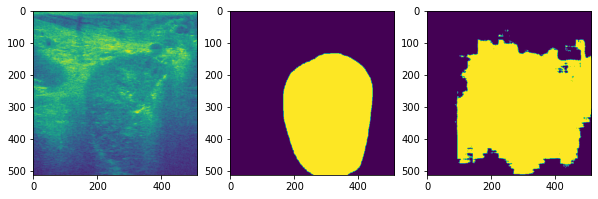

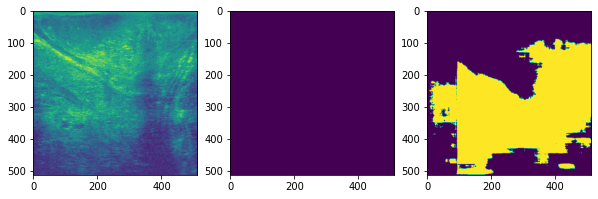

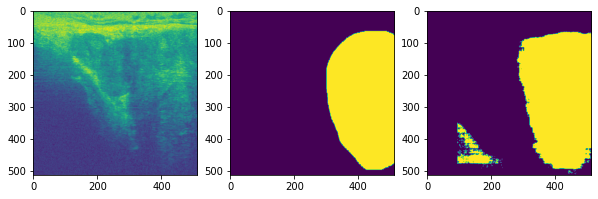

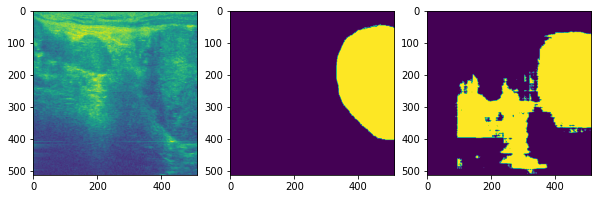

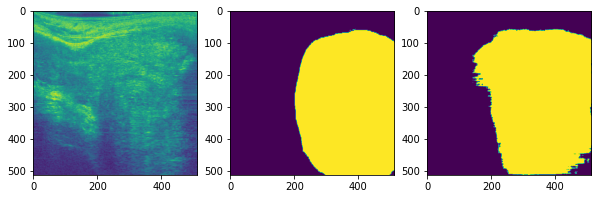

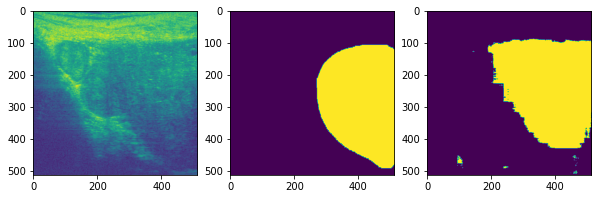

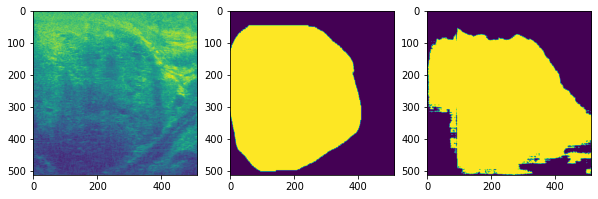

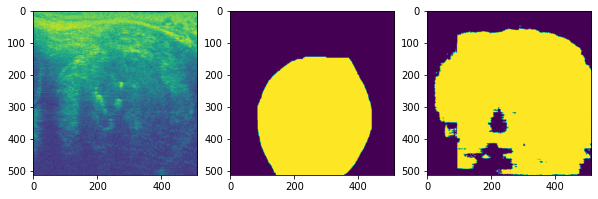

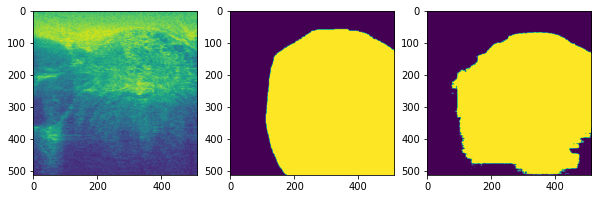

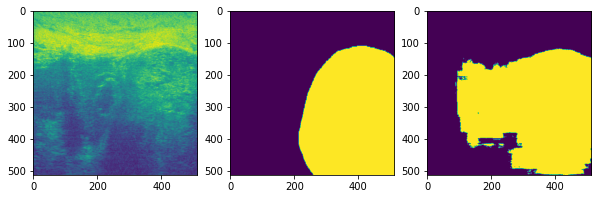

In [23]:
# check model on test sample 
for idx in range(10): 
    bmode, mask, *_ = val_dataset[idx]
    bmode = bmode.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)
    output = model(bmode)
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(bmode.squeeze().cpu().numpy())
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze().cpu().numpy())
    plt.subplot(1, 3, 3)
    plt.imshow(output.argmax(1).squeeze().cpu().numpy())

#bmode, mask, *_ = val_dataset[1]
#
#bmode = bmode.unsqueeze(0).to(device)
#mask = mask.unsqueeze(0).to(device)
#
#output = model(bmode)
#
#plt.figure(figsize=(10, 10))
#plt.subplot(1, 3, 1)
#plt.imshow(bmode.squeeze().cpu().numpy())
#plt.subplot(1, 3, 2)
#plt.imshow(mask.squeeze().cpu().numpy())
#plt.subplot(1, 3, 3)
#plt.imshow(output.argmax(1).squeeze().cpu().numpy())

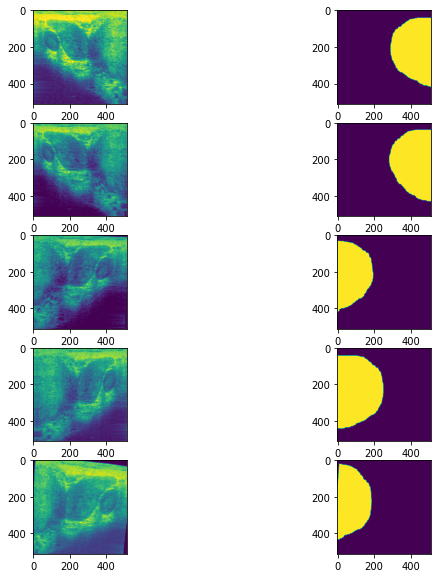

In [28]:
# now try with using some augmentations in training 

train_transform = SegmentationTransform(
    use_augmentations=True, 
    random_brightness=True, 
)

train_dataset.transform = train_transform

# show a few examples of the augmented images
fig, ax = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5): 
    bmode, mask, *_ = train_dataset[0]
    bmode = bmode[0].numpy()
    mask = mask.numpy()
    ax[i, 0].imshow(bmode)
    ax[i, 1].imshow(mask)


In [29]:
model = UNet(1, 2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_loss, train_dice, val_loss, val_dice = train(model, optimizer, loss_fn, train_loader, val_loader, device, epochs=10)


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from inf to 0.5673
Saving model
Epoch 0 Train Loss: 0.5795 Train Dice: 0.6059 Val Loss: 0.5673 Val Dice: 0.5756


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from 0.5673 to 0.4823
Saving model
Epoch 1 Train Loss: 0.5179 Train Dice: 0.6536 Val Loss: 0.4823 Val Dice: 0.7196


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2 Train Loss: 0.4905 Train Dice: 0.6672 Val Loss: 0.5617 Val Dice: 0.6418


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from 0.4823 to 0.4442
Saving model
Epoch 3 Train Loss: 0.4661 Train Dice: 0.6948 Val Loss: 0.4442 Val Dice: 0.7331


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 4 Train Loss: 0.4525 Train Dice: 0.7108 Val Loss: 0.4666 Val Dice: 0.6635


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from 0.4442 to 0.4365
Saving model
Epoch 5 Train Loss: 0.4373 Train Dice: 0.7268 Val Loss: 0.4365 Val Dice: 0.7307


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.4270 Train Dice: 0.7294 Val Loss: 0.5578 Val Dice: 0.6219


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.4204 Train Dice: 0.7374 Val Loss: 0.4374 Val Dice: 0.7685


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from 0.4365 to 0.3895
Saving model
Epoch 8 Train Loss: 0.4141 Train Dice: 0.7422 Val Loss: 0.3895 Val Dice: 0.7672


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9 Train Loss: 0.4017 Train Dice: 0.7540 Val Loss: 0.3900 Val Dice: 0.7770


In [30]:
# keep going 
train_loss, train_dice, val_loss, val_dice = train(model, optimizer, loss_fn, train_loader, val_loader, device, epochs=10)

  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from inf to 0.3909
Saving model
Epoch 0 Train Loss: 0.3943 Train Dice: 0.7567 Val Loss: 0.3909 Val Dice: 0.7893


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1 Train Loss: 0.3949 Train Dice: 0.7588 Val Loss: 0.4047 Val Dice: 0.7480


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2 Train Loss: 0.3933 Train Dice: 0.7609 Val Loss: 0.5314 Val Dice: 0.5419


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3 Train Loss: 0.3892 Train Dice: 0.7627 Val Loss: 0.3986 Val Dice: 0.7325


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from 0.3909 to 0.3691
Saving model
Epoch 4 Train Loss: 0.3832 Train Dice: 0.7651 Val Loss: 0.3691 Val Dice: 0.7752


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.3799 Train Dice: 0.7674 Val Loss: 0.3865 Val Dice: 0.7867


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.3787 Train Dice: 0.7723 Val Loss: 0.3870 Val Dice: 0.7474


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.3730 Train Dice: 0.7738 Val Loss: 0.4156 Val Dice: 0.6993


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.3657 Train Dice: 0.7774 Val Loss: 0.3977 Val Dice: 0.7537


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from 0.3691 to 0.3452
Saving model
Epoch 9 Train Loss: 0.3666 Train Dice: 0.7769 Val Loss: 0.3452 Val Dice: 0.7783


In [31]:
# keep going 
train_loss, train_dice, val_loss, val_dice = train(model, optimizer, loss_fn, train_loader, val_loader, device, epochs=10)

  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from inf to 0.3759
Saving model
Epoch 0 Train Loss: 0.3655 Train Dice: 0.7803 Val Loss: 0.3759 Val Dice: 0.7946


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from 0.3759 to 0.3719
Saving model
Epoch 1 Train Loss: 0.3612 Train Dice: 0.7829 Val Loss: 0.3719 Val Dice: 0.7762


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from 0.3719 to 0.3650
Saving model
Epoch 2 Train Loss: 0.3608 Train Dice: 0.7810 Val Loss: 0.3650 Val Dice: 0.7895


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Validation loss improved from 0.3650 to 0.3511
Saving model
Epoch 3 Train Loss: 0.3581 Train Dice: 0.7872 Val Loss: 0.3511 Val Dice: 0.7825


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 4 Train Loss: 0.3501 Train Dice: 0.7905 Val Loss: 0.3704 Val Dice: 0.7703


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.3516 Train Dice: 0.7933 Val Loss: 0.4522 Val Dice: 0.6480


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.3544 Train Dice: 0.7898 Val Loss: 0.3632 Val Dice: 0.8105


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.3497 Train Dice: 0.7907 Val Loss: 0.4317 Val Dice: 0.7081


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.3513 Train Dice: 0.7932 Val Loss: 0.3975 Val Dice: 0.7519


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9 Train Loss: 0.3460 Train Dice: 0.7993 Val Loss: 0.4136 Val Dice: 0.7417


In [32]:
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

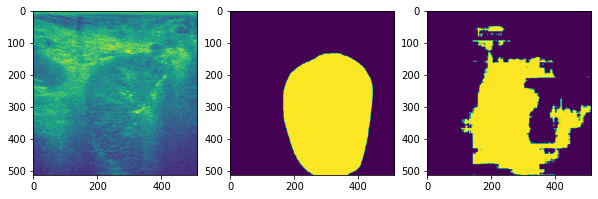

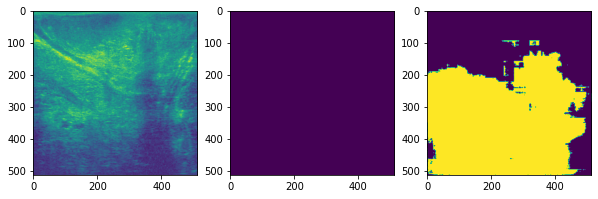

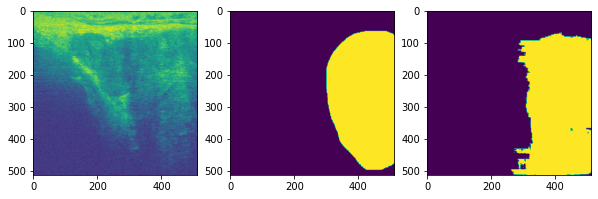

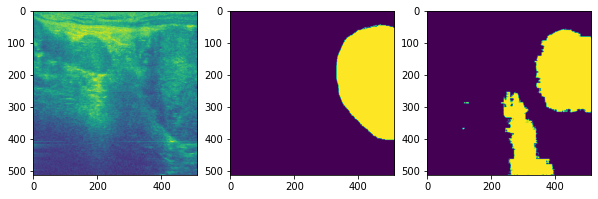

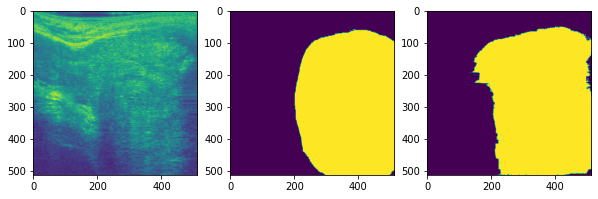

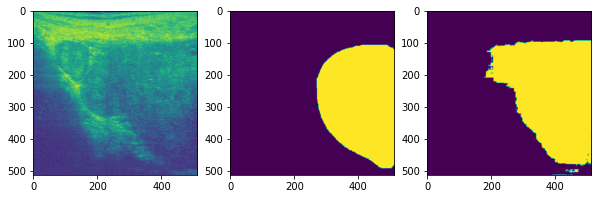

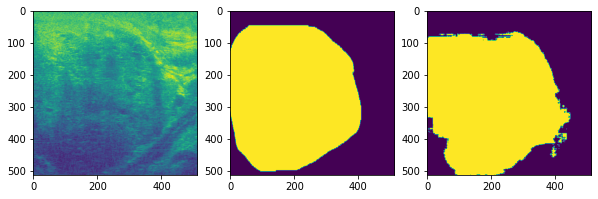

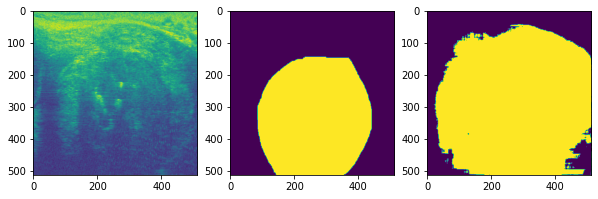

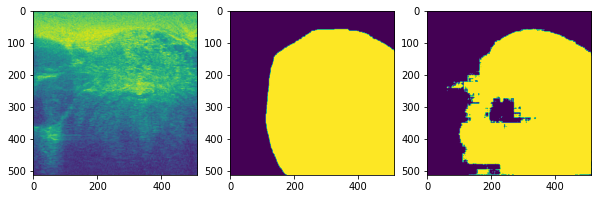

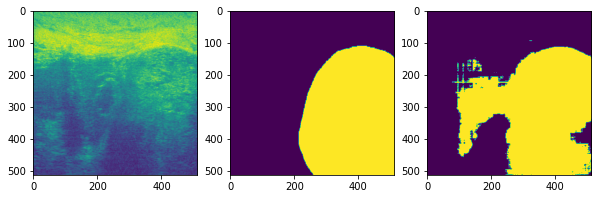

In [33]:
for idx in range(10): 
    bmode, mask, *_ = val_dataset[idx]
    bmode = bmode.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)
    output = model(bmode)
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(bmode.squeeze().cpu().numpy())
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze().cpu().numpy())
    plt.subplot(1, 3, 3)
    plt.imshow(output.argmax(1).squeeze().cpu().numpy())
